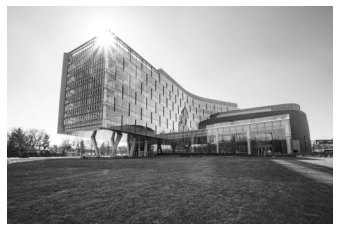

In [1]:
#Do not import any additional modules
import numpy as np
from PIL.Image import open
import matplotlib.pyplot as plt

### Load, convert to grayscale, plot, and resave an image
I = np.array(open('Iribe.jpg').convert('L'))/255

plt.imshow(I,cmap='gray')
plt.axis('off')
plt.show()

plt.imsave('test.png',I,cmap='gray')

#https://stackoverflow.com/questions/29731726/how-to-calculate-a-gaussian-kernel-matrix-efficiently-in-numpy
def gausskernel(sigma):
    ax = np.linspace(-(sigma*3 - 1) / 2., (sigma*3 - 1) / 2., sigma * 3)
    xx, yy = np.meshgrid(ax, ax)
    kernel = (1/(2 * np.pi * np.square(sigma)))* np.exp(-1 * (np.square(xx) + np.square(yy)) /(2*np.square(sigma)))
    return kernel/np.sum(kernel)

In [2]:
def myfilter(I,h):
    #https://www.reddit.com/r/learnpython/comments/79l86u/convolution_of_matrices_in_numpy/
    a,b = I.shape
    x,y = h.shape
     
    x_dif, y_dif = np.subtract((a,b),(x,y))
    lst = []
    for x_i in range(1+x_dif):
        for y_i in range(1+y_dif):
            lst.append(np.sum(np.multiply(I[x_i:x+x_i,y_i:y+y_i],h)))
    result_shape = np.add((x_dif,y_dif),(1,1))
    result = np.reshape(lst, result_shape) 
  
    return result 


h1=np.array([[-1/9,-1/9,-1/9],
             [-1/9, 2,  -1/9],
             [-1/9,-1/9,-1/9]])

h2=np.array([[-1,3,-1]])
h3=np.array([[-1],[3],[-1]])

In [3]:
filter3 = gausskernel(3)
filter5 = gausskernel(5)
filter10 = gausskernel(10)
i_3 = myfilter(I, filter3)
i_5 = myfilter(I, filter5)
i_10 = myfilter(I, filter10)
h_1 = myfilter(I, h1)
h_2 = myfilter(I, h2)
h_3 = myfilter(I, h3)

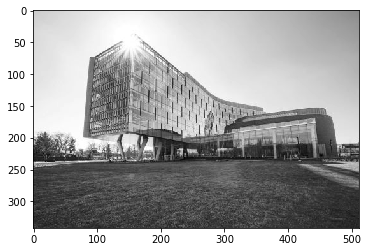

In [4]:
plt.imshow(I, interpolation='none', cmap='gray')

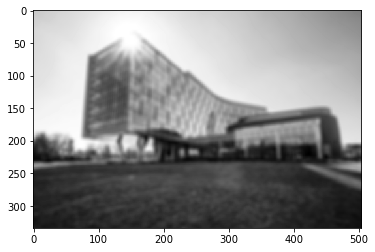

In [5]:
plt.imshow(i_3, interpolation='none', cmap='gray')
plt.imsave('blur3.png',i_3,cmap='gray')

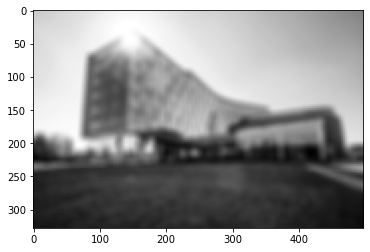

In [6]:
plt.imshow(i_5, interpolation='none', cmap='gray')
plt.imsave('blur_5.png',i_5,cmap='gray')

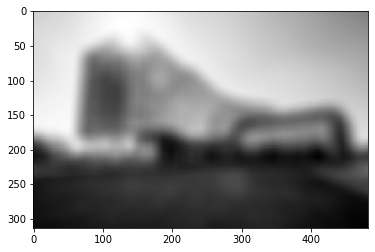

In [7]:
plt.imshow(i_10, interpolation='none', cmap='gray')
plt.imsave('blur_10.png',i_10,cmap='gray')

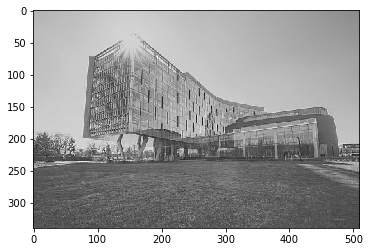

In [8]:
plt.imshow(h_1, interpolation='none', cmap='gray')
plt.imsave('filter_h1.png',h_1,cmap='gray')

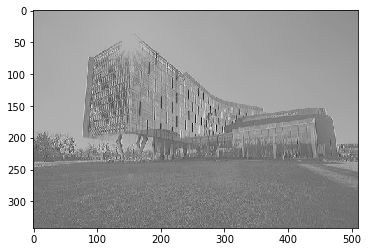

In [9]:
plt.imshow(h_2, interpolation='none', cmap='gray')
plt.imsave('filter_h2.png',h_2,cmap='gray')

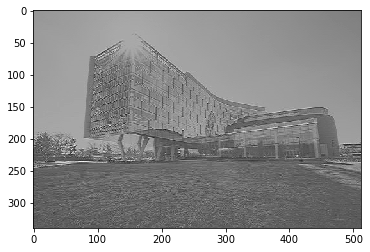

In [10]:
plt.imshow(h_3, interpolation='none', cmap='gray')
plt.imsave('filter_h3.png',h_3,cmap='gray')

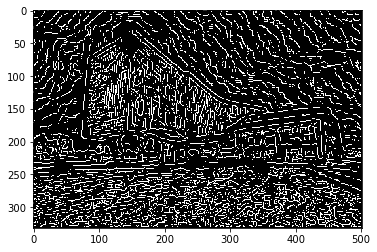

In [11]:
### Part 2
Sx=np.array([[1,0,-1],
             [2,0,-2],
             [1,0,-1]])
Sy=np.array([[-1,-2,-1],
             [0,0,0],
             [1,2,1]])
# https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123
def myCanny(I,sigma=1,t_low=.5,t_high=1):
    #t_low = t_low * 255 
    #t_high = t_high * 255
    #Smooth with gaussian kernel
    h = gausskernel(sigma)
    smoothedImg = myfilter(I,h)
    
    #Find img gradients
    Ix = myfilter(smoothedImg, Sx)
    Iy = myfilter(smoothedImg, Sy)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    theta = theta * 180. / np.pi
    theta = np.where(theta < 0, theta + 180, theta)
    
    #Thin edges
    a, b = G.shape
    Z = np.zeros((a,b))
    x_dif, y_dif = np.subtract((a,b),(3,3))
    
    for i in range(x_dif+1):
        for j in range(y_dif+1):
#             try:
            q = 255
            r = 255
                
           #angle 0
            if (0 <= theta[i,j] < 22.5) or (157.5 <= theta[i,j] <= 180):
                q = G[i, j+1]
                r = G[i, j-1]
            #angle 45
            elif (22.5 <= theta[i,j] < 67.5):
                q = G[i+1, j-1]
                r = G[i-1, j+1]
            #angle 90
            elif (67.5 <= theta[i,j] < 112.5):
                q = G[i+1, j]
                r = G[i-1, j]
            #angle 135
            elif (112.5 <= theta[i,j] < 157.5):
                q = G[i-1, j-1]
                r = G[i+1, j+1]

            if (G[i,j] >= q) and (G[i,j] >= r):
                Z[i,j] = G[i,j]
            else:
                Z[i,j] = 0
    
    #Hystersis thresholding
    from scipy.ndimage.measurements import label
    
    # Labeling and making sure that diagonal labels work properly
    s = [[1,1,1],
        [1,1,1],
        [1,1,1]]
    pr = np.where(Z > t_low, 255, 0)
    lb, num_labels = label(pr, structure = s)
    
    # Find the coordinates of the non-zero elements 
    nz = np.nonzero(lb)
    coords = np.column_stack(nz)
    nzvals = lb[nz[0], nz[1]]
    res = {k:coords[nzvals == k] for k in range(1, num_labels + 1)}
    bol = {}
    for r in res: 
        ls = res[r]
        for i in ls: 
            if Z[i[0]][i[1]] >= (t_high): 
                bol[r] = True 
            else: 
                bol[r] = False
                
    for i in range (x_dif + 1): 
        for j in range (y_dif + 1): 
            if (Z[i][j] >= t_high):
                Z[i][j] = 255 
            elif (Z[i][j] <= t_low):
                Z[i][j] = 0
            else: 
                if(bol[lb[i][j]]): 
                    Z[i][j] = 255 
                else: 
                    Z[i][j] = 0
        
    
    myedges = Z
    return myedges

edges =myCanny(I,sigma=3,t_low = 0.5, t_high= 1)
plt.imshow(edges, interpolation='none', cmap = 'gray')
plt.imsave('edges.png',edges,cmap='gray')
plt.show()

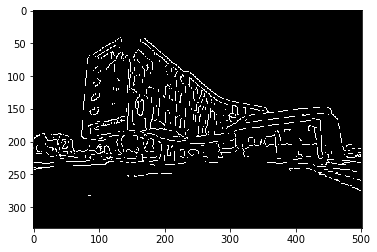

In [12]:
edges2 =myCanny(I,sigma=3,t_low = 10, t_high= 50)
plt.imshow(edges2, interpolation='none', cmap = 'gray')
plt.imsave('edges_2.png',edges2,cmap='gray')
plt.show()

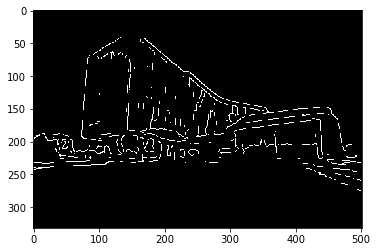

In [13]:
edges_3 =myCanny(I,sigma=3,t_low = 5, t_high= 80)
plt.imshow(edges_3, interpolation='none', cmap = 'gray')
plt.imsave('edges_3.png',edges_3,cmap='gray')
plt.show()

In [14]:
## Extra Credit 

# Hybrid images 
# https://hicraigchen.medium.com/digital-image-processing-using-fourier-transform-in-python-bcb49424fd82
def distance(point1,point2):
    return ((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)**(1/2)

# These two functions essentially make the shape of a circle and each make their own filters for 
# low pass and high pass filtering respectively
# Everything is empty besides a middle circle 
def idealFilterLP(D0,imgShape):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            if distance((y,x),center) < D0:
                base[y,x] = 1
    return base

# Everything is full besides the circle 
def idealFilterHP(D0,imgShape):
    base = np.ones(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            if distance((y,x),center) < D0:
                base[y,x] = 0
    return base

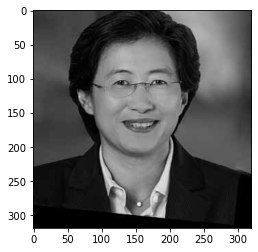

In [15]:
x = np.array(open('amd.jpg').convert('L'))/255

plt.imshow(x, "gray")
plt.imsave('amd_ceo.png',x,cmap='gray')

In [16]:
a = x

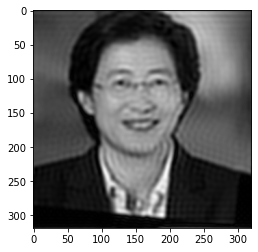

In [17]:
X_2 = np.fft.fft2(a)
X_shifted = np.fft.fftshift(X_2)
LPCen = X_shifted * idealFilterLP(35, a.shape)
LP = np.fft.ifftshift(LPCen)
rawr = np.fft.ifft2(LP)
plt.imshow(np.abs(rawr), "gray")
plt.imsave('amd_ceo_low.png',np.abs(rawr),cmap='gray')
plt.show()

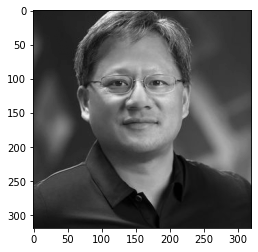

In [18]:
x = np.array(open('nvidia.jpg').convert('L'))/255
plt.imsave('nvidia_ceo.png',x,cmap='gray')
plt.imshow(x,"gray")

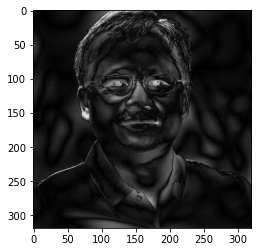

In [19]:
X_2 = np.fft.fft2(x)
X_shifted = np.fft.fftshift(X_2)
LPCen = X_shifted * idealFilterHP(5, x.shape)
LP = np.fft.ifftshift(LPCen)
Inv_LP = np.fft.ifft2(LP)
plt.imshow(np.abs(Inv_LP), "gray")
plt.imsave('nvidia_ceo_high.png',np.abs(Inv_LP),cmap='gray')
plt.show()

In [20]:
b = rawr + Inv_LP 

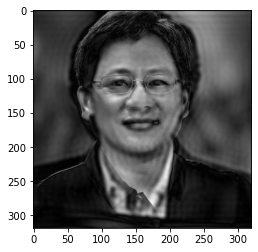

In [21]:
plt.imshow(np.abs(b), "gray")
plt.imsave('hybrid.png',np.abs(b),cmap='gray')